In [2]:
from typing import List, Dict
import numpy as np
import matplotlib.pyplot as plt

from PV_Generation import generate_PV_profile
from Load_Profiles import generate_load_profile
from Price_Forecast import generate_price_profile
from Agents import Prosumer
from Market import match_trades, match_local_market
from Regulator import Regulator
from BlockChain import Blockchain


In [6]:
def run_simulation(
    num_prosumers: int = 200,
    num_steps: int = 24,
    block_chain_difficulty: int = 3
) -> Dict:

    # ---------------- Initialization ----------------

    prosumers: List[Prosumer] = []
    for i in range(num_prosumers):
        has_pv = (i < int(0.7 * num_prosumers))
        prosumers.append(Prosumer(id=i, has_pv=has_pv))

    pv, capacities = generate_PV_profile(num_prosumers, num_steps)
    loads = generate_load_profile(num_prosumers, num_steps)
    grid_price, fit_price = generate_price_profile(num_steps)

    regulator = Regulator(objective="maximize_p2p")

    blockchain = Blockchain(
        difficulty=block_chain_difficulty,
        miner_ids=list(range(10))
    )

    history = {
        "total_load": [],
        "total_pv": [],
        "p2p_energy": [],
        "local_energy": [],
        "grid_import": [],
        "grid_export": [],
        "community_profit": [],
        "p2p_share": [],
        "objective_value": []
    }

    # ---------------- Time loop ----------------
    for t in range(num_steps):

        asks = []
        bids = []
        
        imbalances = np.zeros(num_prosumers)

        sold = np.zeros(num_prosumers)
        bought = np.zeros(num_prosumers)

        # ---- Self-balance + offers ----
        for i, p in enumerate(prosumers):

            pv_t = pv[i, t] if p.has_pv else 0.0
            load_t = loads[i, t]

            imbalance = p.self_balance(load_t, pv_t)
            imbalances[i] = imbalance

            role, qty, price = p.decide_P2P_offer(
                imbalance=imbalance,
                grid_price_t=grid_price[t]
            )

            if role == "seller":
                asks.append((p.id, qty, price))
            elif role == "buyer":
                bids.append((p.id, qty, price))

        # ---- P2P market ----
        p2p_trades, rem_asks, rem_bids = match_trades(asks, bids)

        # ---- Local market ----
        local_trades, _, _ = match_local_market(
            rem_asks, rem_bids, grid_price[t]
        )

        p2p_energy = 0.0
        local_energy = 0.0

        # ---- Apply trades ----

        for tr in p2p_trades:
            s, b = tr["seller"], tr["buyer"]
            q, pr = tr["quantity"], tr["price"]

            prosumers[s].apply_trade_result("seller", q, pr)
            prosumers[b].apply_trade_result("buyer", q, pr)

            sold[s] += q
            bought[b] += q
            p2p_energy += q

        for tr in local_trades:
            s, b = tr["seller"], tr["buyer"]
            q, pr = tr["quantity"], tr["price"]


            prosumers[s].apply_trade_result("seller", q, pr)
            prosumers[b].apply_trade_result("buyer", q, pr)

            sold[s] += q
            bought[b] += q
            local_energy += q

        # ---- Grid settlement ----
        grid_import = 0.0
        grid_export = 0.0

        for i, p in enumerate(prosumers):
            remaining = imbalances[i] - sold[i] + bought[i]

            gi, ge = p.settle_with_grid(
                remaining_imbalance=remaining,
                grid_price_t=grid_price[t],
                fit_price=fit_price
            )
            grid_import += gi
            grid_export += ge

        # ---- Metrics ----
        total_load = loads[:, t].sum()
        total_pv = pv[:, t].sum()
        community_profit = sum(p.money for p in prosumers)

        traded_total = p2p_energy + local_energy
        p2p_share = p2p_energy / (traded_total + 1e-6)

        stats_t = {
            "total_load": total_load,
            "total_pv": total_pv,
            "p2p_energy": p2p_energy,
            "local_energy": local_energy,
            "grid_import": grid_import,
            "grid_export": grid_export,
            "community_profit": community_profit,
            "p2p_share": p2p_share
        }

        for k in stats_t:
             history[k].append(stats_t[k])


        # ---- Regulator ----
        obj_value = regulator.evaluate_objective(stats_t)
        history["objective_value"].append(obj_value)
        regulator.apply_rules(prosumers)

        # ---- Blockchain (ONE BLOCK PER STEP) ----
        blockchain.mine_block(p2p_trades + local_trades)

    # ---------------- Return ----------------
    return {
        "history": history,
        "blockchain": blockchain,
        "raw_data": {
            "pv": pv,
            "loads": loads,
            "grid_price": grid_price,
            "fit_price": fit_price,
            "capacities": capacities
        }
    }



In [7]:
results = run_simulation()

history = results["history"]
raw = results["raw_data"]
blockchain = results["blockchain"]


In [8]:
import numpy as np

print("===== GLOBAL NUMERICAL RESULTS =====")

print(f"Total energy demand: {np.sum(history['total_load']):.1f} kWh")
print(f"Total PV generation: {np.sum(history['total_pv']):.1f} kWh")

print(f"Total P2P traded energy: {np.sum(history['p2p_energy']):.1f} kWh")
print(f"Total local market energy: {np.sum(history['local_energy']):.1f} kWh")

print(f"Total grid import: {np.sum(history['grid_import']):.1f} kWh")
print(f"Total grid export: {np.sum(history['grid_export']):.1f} kWh")

print(f"Final community profit: {history['community_profit'][-1]:.2f} €")

avg_p2p_share = np.mean(history["p2p_share"])
print(f"Average P2P share: {avg_p2p_share:.2f}")


===== GLOBAL NUMERICAL RESULTS =====
Total energy demand: 3981.7 kWh
Total PV generation: 5331.5 kWh
Total P2P traded energy: 85.7 kWh
Total local market energy: 0.0 kWh
Total grid import: 3322.8 kWh
Total grid export: 2918.4 kWh
Final community profit: -595.03 €
Average P2P share: 0.25


- PV vs Load

- This plot shows when the community has surplus/dificit 
- p2p trading only emerges when PV exceed load

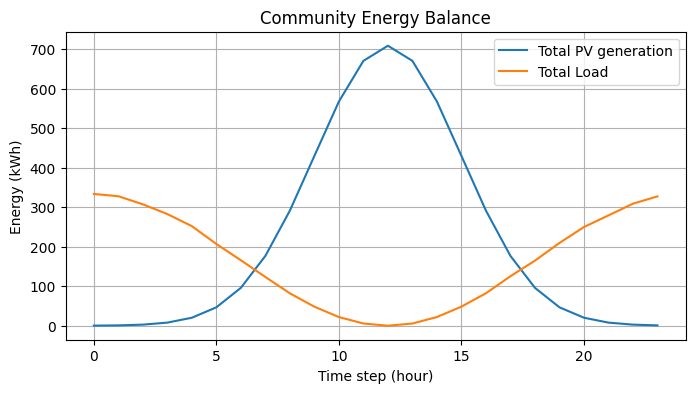

In [10]:

plt.figure(figsize=(8,4))
plt.plot(history["total_pv"], label="Total PV generation")
plt.plot(history["total_load"], label="Total Load")
plt.xlabel("Time step (hour)")
plt.ylabel("Energy (kWh)")
plt.title("Community Energy Balance")
plt.legend()
plt.grid(True)
plt.show()

- Market Activity 
- p2p + Local Market 

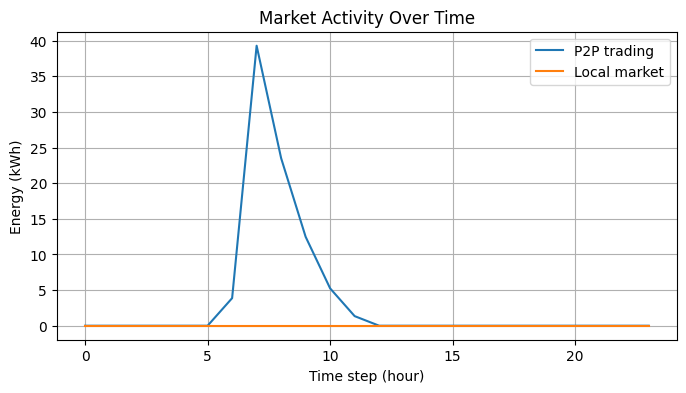

In [11]:
plt.figure(figsize=(8,4))
plt.plot(history["p2p_energy"], label="P2P trading")
plt.plot(history["local_energy"], label="Local market")
plt.xlabel("Time step (hour)")
plt.ylabel("Energy (kWh)")
plt.title("Market Activity Over Time")
plt.legend()
plt.grid(True)
plt.show()


- Grid Interaction 

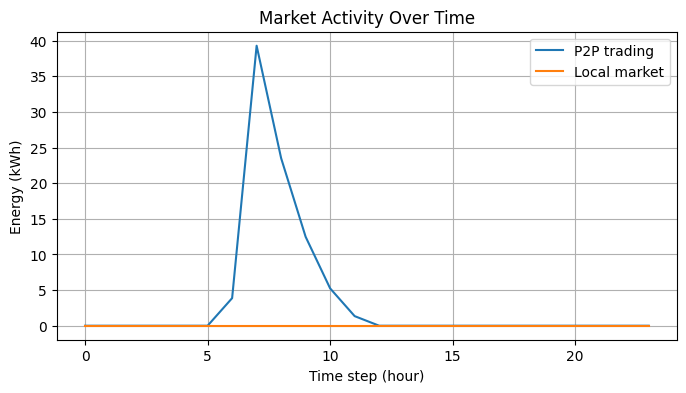

In [12]:
plt.figure(figsize=(8,4))
plt.plot(history["p2p_energy"], label="P2P trading")
plt.plot(history["local_energy"], label="Local market")
plt.xlabel("Time step (hour)")
plt.ylabel("Energy (kWh)")
plt.title("Market Activity Over Time")
plt.legend()
plt.grid(True)
plt.show()


- Regulation Effect 

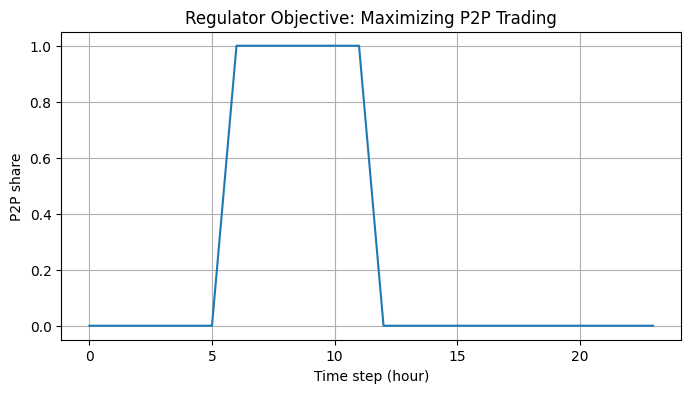

In [13]:
plt.figure(figsize=(8,4))
plt.plot(history["p2p_share"])
plt.xlabel("Time step (hour)")
plt.ylabel("P2P share")
plt.title("Regulator Objective: Maximizing P2P Trading")
plt.grid(True)
plt.show()


- Economic Outcome

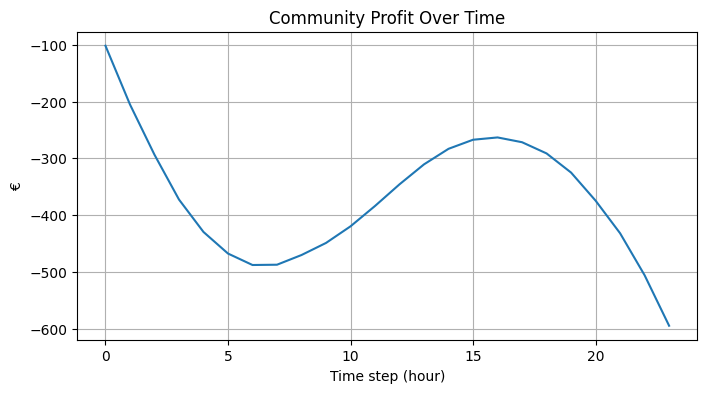

In [15]:
plt.figure(figsize=(8,4))
plt.plot(history["community_profit"])
plt.xlabel("Time step (hour)")
plt.ylabel("€")
plt.title("Community Profit Over Time")
plt.grid(True)
plt.show()


- Block chain result 

In [17]:
print("===== BLOCKCHAIN SUMMARY =====")
print(blockchain.summary())
print("Blockchain valid:", blockchain.is_valid())


===== BLOCKCHAIN SUMMARY =====
{'num_blocks': 25, 'total_transactions': 539, 'difficulty': 3, 'num_miners': 10, 'last_hash': '0003725779dedbab6ff9efe3f3c68ce6b9737776a266faf48ffa0aa4e6124f4f'}
Blockchain valid: True


Load profile of the community

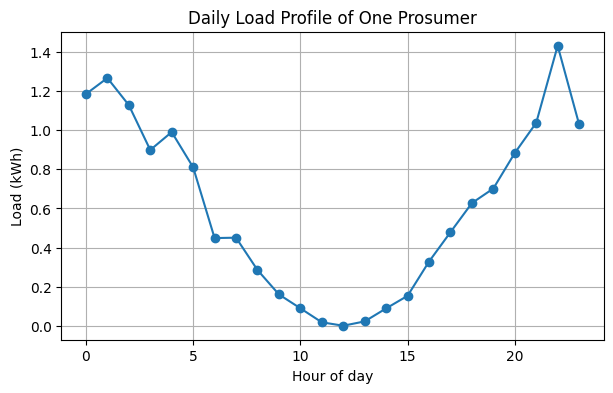

In [38]:
# Generate load data for one day
num_prosumers = 200
num_steps = 24

loads = generate_load_profile(num_prosumers, num_steps)

# Pick one prosumer
i = 0
hours = np.arange(num_steps)

toal_load = loads.sum(axis=0)

plt.figure(figsize=(7,4))
plt.plot(hours, loads[i], marker='o')
plt.xlabel("Hour of day")
plt.ylabel("Load (kWh)")
plt.title("Daily Load Profile of One Prosumer")
plt.grid(True)
plt.show()


- Night :
    -- low consumption 
    -- base load only 

- Morining :
    -- Moderate rise 

- Midday 
    -- Min consumption 
    -- possibly away from home 

- Evening :
    -- Clear peak 

=> this plot shows micro level behavior that, when aggreagted, produces the system-level dynamic 

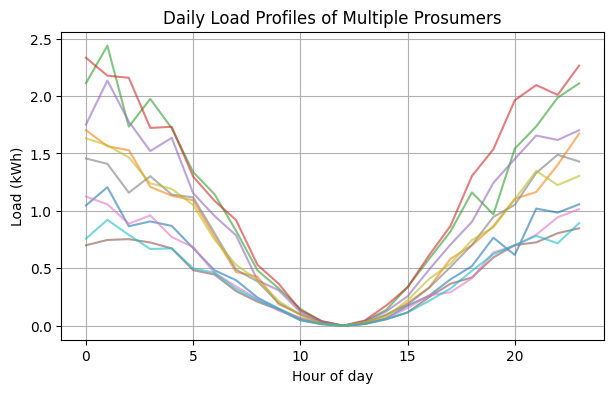

In [28]:
plt.figure(figsize=(7,4))

for i in range(10):  # plot 10 random prosumers
    plt.plot(hours, loads[i], alpha=0.6)

plt.xlabel("Hour of day")
plt.ylabel("Load (kWh)")
plt.title("Daily Load Profiles of Multiple Prosumers")
plt.grid(True)
plt.show()


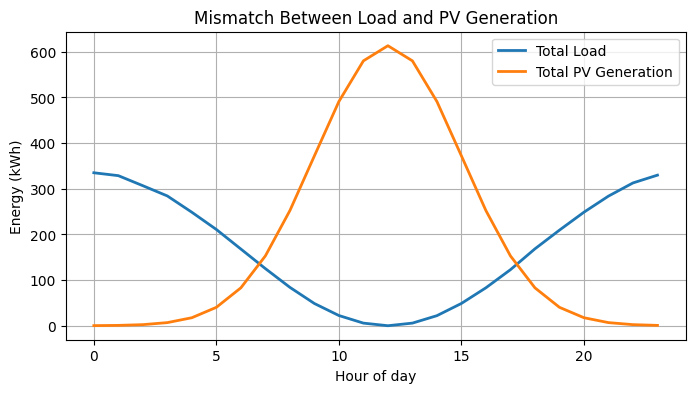

In [21]:
pv, _ = generate_PV_profile(num_prosumers, num_steps)
loads = generate_load_profile(num_prosumers, num_steps)

total_pv = pv.sum(axis=0)
toal_load = loads.sum(axis=0)

plt.figure(figsize=(8,4))
plt.plot(hours, toal_load, label="Total Load", linewidth=2)
plt.plot(hours, total_pv, label="Total PV Generation", linewidth=2)
plt.xlabel("Hour of day")
plt.ylabel("Energy (kWh)")
plt.title("Mismatch Between Load and PV Generation")
plt.legend()
plt.grid(True)
plt.show()


- Night & Early morning (0-6) :
    -- pv generation ~ 0
    -- load is high 
    -- Net dificit 
=> at night the community relies on the grid since we do not have renewable generation 

- Morning (6-9):
    -- PV starts increasing
    -- Load decreases 

=> As the sun rises, renewable generation starts to offset part of the demandm reducing grid dependence 

- Midday(10-14) :
    -- PV exceeds load
    -- large surplus 

=> this is when the surplus energy is available inside the community, enabling peer-to-peer trading 

- Afternoon(15-23):
    -- PV decreases rapidly 
    -- load increases again

=> the mismatch reverses, leading to increasing reliance on grid imports 